# Introduction

This notebook contains my work and thoughts used to solve the "Natural Language Processing with Disaster Tweets"-Challenge as part of the recruiting process for 42hacks. The notebook consists of three parts: First, a written part that shows my thoughts, my approach and my results, followed by the code part. At the end there's the Appendix which contains the outputs, data, graphs etc. which are the basis of the first part as well as some literature and other solutions which were inspiring and supporting.

***Important note:*** The task was performed on the Kaggle plattform using the GPU P100 accellerator. The measured times, iterations/s and other platform-dependent results are therefore based on the aforementioned infrastructure.

# Approach & Results
## Steps taken *and recommended for futher improvement*
1. Implement a Network strongly inspired by [this solution](https://www.auroria.io/nlp-disaster-tweet-text-classification-roberta-pytorch/), featuring the RoBERTa model, a version of the well known Google BERT model.
1. Improve the NLP-NN
    1. Limit and reduce the number of tokens per tweet by analyzing the tokenized data to improve the speed of the NN significantly
    1. Find a faster alternative for Roberta with as little loss of accuracy as possible
    1. Preprocess and optimize the text data to be able to use a smaller ammount of tokens thanks to the higher information density
        1. Remove links, multiple spaces and transform to lowercase
        1. All the points from above as well as removing mentions, retweets, all special characters and stopwords
1. Consider the features keyword and location
    1. Estimate the amount of information contained in keyword and location - it's quite high! (F1 of 0.68 with keyword data only)
    1. Train a binary classifier to model the correlation between keyword and target
    1. Combine the predictions based on the Tweet-text and the keyword to get better results
1. *Improve further*

## Discussion
In this section the taken steps are discussed and the reasons for the decisions made will be explained

### Step 1 - implement a first NN
When we talk about NLP Text Classification, there is no getting around BERT and versions of it. There are also other promising approaches, such as XLNet and ELECTRA, but due to the diversity and popularity of BERT versions and the limited time available, this work will start of with a version of BERT (RoBERTa).
The first version of the implementation was quite simple with basic tokenization, no preprocessing of the text and a basic training method (Adam, BCELoss, lr=1e-5 and early stopping after the first time the the validation loss is smaller than the best loss so far. There are not many epochs necessary as the network is already pretrained - the training here is just to adapt the network to the given task.
With this version, one training epoch took 5:25min, the validation accuracy 0.848 and the F1-Score with the test data was 0.80169 which is not too bad.

***Note:*** The F1-Score varies significantly when training the network multiple times with the same parameters, so this measure shouldn't be overrated - especially because these are test data and should NEVER be used for model selection. Also the other metrics (accuracy, loss) have some fluctuation and  should therefore also be treated with caution.

### Step 2 - Improve the NLP-NN
#### Reduce #tokens per Tweet
First of all, the structure of the tokenized data was analyzed and it could be seen that no tweet resulted in more than 85 tokens. Thus the max_length of the tokenized input could be fixed to 85 without losing any accuracy and information but with improving the training speed from 5:25min/epoch to 1:10min/epoch, which is more than 4.5 times faster. By truncating the tokenized input, the model speed can be improved even more - around 1.6x, from 1:10min to 0:44min - without lowering the model performance (to the extent that this can be determined due to the magnitude of the aforementioned fluctuation of the metrics).
#### Find a faster alternative for RoBERTa
Speaking of performance, there is way more potential. Usually, performance improvements come at the cost of accuracy and so finding the right trade-off is a major challenge. In this task, there are no limits on the ressources specified as well as no real requirement of accuracy (except the expected F1-Score of 0.7 which seems relatively low). Therefore, the performance improvements are made to an extent where the ratio between improvement and loss of accuracy feels reasonable.
In this process, four new models were tried - *google/mobilebert-uncased*, *distilroberta-base*, *distilbert-base-uncased* and *prajjwal1/bert-tiny*. As the mobilebert is optimized for mobile devices, it wasn't a fit with this plattform - the CPU became the bottleneck, not the GPU - which resulted in a longer training time than the RoBERTa. The remaining three models were evaluated and the bert-tiny has been found the most efficient with only 0:05min/epoch, which is 14x faster than the RoBERTa without truncation and 7x faster than the second fastest, distilbert-base-uncased. Here it could also been noticed, that the GPU was way below 100% utilization.

If there is a higher accuracy needed, with *distilroberta-base* and *distilbert-base-uncased*, two other alternatives have been found which are almost two times faster as the untruncated RoBERTa.

#### Preprocess and optimize textdata
There are a lot of different ways to preprocess data. The goal of it is to higher the information density and reduce noise. In this work, there were two levels of preprocessing tested - a lite version which removes links (which contain no information at all as they are shortened), multiple spaces and transforms to lowercase and an other version which additionally removes mentions, retweets, all special characters and stopwords. Removing these parts results in a shorter string as well as a shorter tokenized version - ideally with a higher information density such that all information is retained. Given that the used plattform is way too powerful to be brought to the limit by this network, the tradeoff is hardly doable as measuring the performance improvement by shortening the tokenization is not straightforward. Thus we go with the lite preprocessing and the truncation at 60 tokens. Nontheless it needs to be mentioned here that the performance is also quite impressive with way less tokens, e.g. 30.

### Step 3 - Consider the features keyword and location
#### Investigate Data and implement binary classifier
There is more data in the dataset than just the tweet text bodies. There is also a keyword and a location. Inspecting the data shows that there are 222 different keywords which are distributed quite well over the tweets - on average in the training data a keyword has 34.29 tweets, the standard deviation is 5.09 and the min number of tweets per keyword is 9, the max 61. This has the potential to be quite a good source of information (even though in theory every keyword could be distributed around equaly over the targets). Typical approaches for binary classification with few features are LogisticRegression, SVM, Naive Bayes, KNN and random forests. Of course it would also be possible to fit a simple NN to it but this feels like cracking a walnut with a sledgehammer. Fitting a simple binary classifier shows that the keyword is really helpful in classifying the tweets. Fitting a simple Gaussian Naive Bayes to the One Hot Encoded Data results in an accuracy of 72.33% and an F1-Score of 0.68081.
The location could also contain some information, are way less well distributed though and here not further investigated as there are 4522 different locations (of which some are the same but written in a different way and 2533 tweets without a location in the training set.

#### Combine Prediction data
There are differnet approaches to combine the different predictions. The simplest way is to just average the probabilities of the NN and the binary classifier, another would be to fit a binary classifier to the probabilities. Alternatively the correlation between the probability and the label could be calculated and given as an input feature to the final classifier.
By combining the two predictions, we can clearly show that the accuracy and the F1-score can be improved. To find exact values, many trials need to be done, but here for example an F1-Score of 0.74743 could be improved to 0.75591 by averaging the probabilities of the NN and the LogisticRegression and to 0.76767 by fitting a GaussianNB to the probabilities.

### Step 4 - Improve further
There is a lot of room for further improvement. One could try other NLP-Models like e.g. XLNet, ELECTRA as well as other versions of BERT - there are tons of models out there, e.g. [here](https://huggingface.co/models). The whole training process of the NN could be improved by implementing Cross Validation and finding ideal parameters, the best Text-Preprocessing method and number of tokens. Of course also the training method could be optimized. Additionally, one could make use of the location data and try way more ways to combine the output of the NN with the information contained in keyword and location and find the best parameters for the classifier with grid search. And last but not least, the code could be optimized for performance.

## Conclusion

This work shows my approach to the problem and the necessary steps to achieve a good result given the data. Of course every step could have been made way more elaborate (more different models, parameters etc. as well as averaging over many trials to get more stable results) but given the limited amount of time, only a few variants could be tested. Still, the basis is there and from here it could be taken further and adapted to the given usecase but due to the limited time available, the goal of this work is to show how to approach this challenge, the necessary steps and finding a solution according to the pareto principle, not the optimal solution (if it ever can be found...)
It could be shown that the NLP task can be solved with relatively little computing power with a relatively high accuracy and how the keyword data enables a better prediction with little additional effort.

# Implementation
## Imports & Global Constants

In [173]:
MODEL_NAME = "prajjwal1/bert-tiny" #"roberta-base","google/mobilebert-uncased", "distilroberta-base" "distilbert-base-uncased", "prajjwal1/bert-tiny"
PADDING_MAX_LENGTH = 60
PREPROCESS_TEXT = True #Be careful, in which ways the text is going to be preprocessed has to be adapted to the used model and can be defined in the DisasterData-Class by commenting/uncommenting the specific steps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader


from transformers import AutoModel, AutoTokenizer

import re
import nltk
import string
from tqdm import tqdm

## Data
### Read

In [174]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

train_df_unlabeld = train_df
train_df_unlabeld.drop("target", axis=1)
all_data_unlabeld = pd.concat([train_df, test_df])

sample_solution = pd.read_csv("/kaggle/input/musterloesung-disaster/submission.csv") #True Test Labels

### Preprocess

In [175]:
all_locations = all_data_unlabeld.location.unique()
all_keywords = all_data_unlabeld.keyword.unique()

#Sparse not possible becuase of the SVM input
locations_one_hot_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
locations_one_hot_encoder.fit(all_locations.reshape(-1, 1))
n_locations = len(all_locations)
keywords_one_hot_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
keywords_one_hot_encoder.fit(all_keywords.reshape(-1, 1))
n_keywords = len(all_keywords)

In [176]:
# This class is here to generate and hold tokenized data from the raw dataset. If desired, the texts can also be preprocessed.
class DisasterData(Dataset):
    _textdata = None
    _labels = None
    
    #Expects a Pandas Dataframe, a Tokenizer, max_length for padding/truncation and a boolean if preprocessing of the texts is wanted.
    def __init__(self, dataframe, tokenizer, max_length=100, preprocess_text=True):
        textdata = dataframe.text.values.tolist()
        if preprocess_text:
            textdata = [self._preprocess_text(text) for text in textdata]
        self._textdata = [tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt") for text in textdata]
            
        if 'target' in dataframe:
            self._labels = dataframe.target.values.tolist()
        else:
            self._labels = [-1 for x in range(dataframe.shape[0])]
    
    def _preprocess_text(self, text):
        #text = re.sub(r'(@.*?)[\s]', ' ', text) #remove mentions
        text = re.sub(r'\s+', ' ', text) #remove multiple spaces
        #text = re.sub(r'^RT[\s]+', ' ', text) #remove retweets
        text = re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text) #remove links (contain no information because of th shortening)
        #text = text.replace("&amp;", " ") #remove ampersands
        #text = re.sub(r'#', ' ', text) #remove hashes
        #text = re.sub(r'[^\w\s]', ' ', text) #remove special characters
        #text = re.sub(r'\d+', ' ', text) #remove numbers
        text = text.lower() #lowercase
        #text = ''.join(character for character in text if character not in string.punctuation) #remove punctuation
        
        #remove stopwords
        #text_tokens = nltk.word_tokenize(text, language="english")
        #stop_words = nltk.corpus.stopwords.words('english')
        #text_tokens = [token for token in text_tokens if token not in stop_words]
        #porter = nltk.stem.porter.PorterStemmer()
        #text_tokens = [porter.stem(token) for token in text_tokens]
        #text = " ".join(text_tokens)
        
        return text
        
    def __len__(self):
        return len(self._textdata)

    def __getitem__(self, idx):
        return self._textdata[idx], self._labels[idx]
    
    def get_tokenized_data(self):
        return self._textdata

### Analyze

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


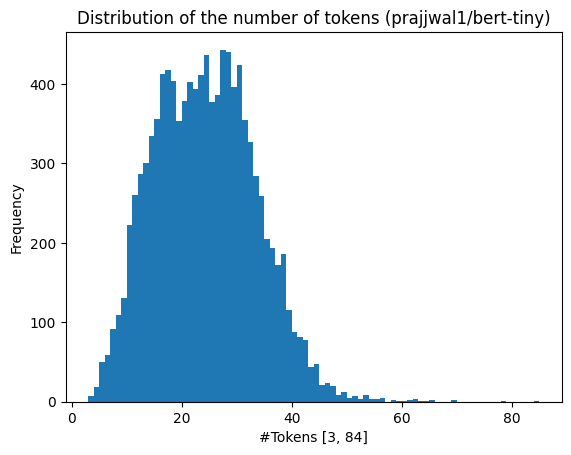

In [177]:
#The way of tokenization depends on the chosen Network. Roberta uses Byte Pair Encoding(BPE) for example, so a reasonable max_length depends on the tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
analysis_data = DisasterData(all_data_unlabeld, tokenizer, max_length=None, preprocess_text=PREPROCESS_TEXT)

num_tokens = [] 
for d in analysis_data.get_tokenized_data():
    num_tokens.append(int(torch.sum(d["attention_mask"]).numpy()))

min_ = np.min(num_tokens)
max_ = np.max(num_tokens)
plt.hist(num_tokens, range=(min_,max_+1), bins=max_-min_+1)
plt.title('Distribution of the number of tokens ({})'.format(MODEL_NAME))
plt.xlabel('#Tokens [{}, {}]'.format(min_, max_))
plt.ylabel('Frequency')
plt.show()

## NLP-NN
### Implementation

In [178]:
class DisasterPredictor(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self._automodel = AutoModel.from_pretrained(model_name)
        
        if model_name == "prajjwal1/bert-tiny":
            self.fc1 = nn.Linear(128, 32)
        elif model_name == "google/mobilebert-uncased":
            self.fc1 = nn.Linear(512, 32)
        else:
            self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        automodel_out = self._automodel(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        x = self.fc1(automodel_out)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    best_val_loss = float('inf')
    early_stopping_threshold_count = 0
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0    
        model.train()
        
        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            train_label = train_label.to(device)
            output = model(input_ids, attention_mask)
            loss = criterion(output, train_label.float().unsqueeze(1))
            total_loss_train += loss.item()
            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            
            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)
                val_label = val_label.to(device)
                output = model(input_ids, attention_mask)
                loss = criterion(output, val_label.float().unsqueeze(1))
                total_loss_val += loss.item()
                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc
                
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"best_model.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1
                
            if early_stopping_threshold_count >= 1:
                print("Early stopping")
                break

### Configuration & Training

In [182]:
data_args = {
    "max_length" : PADDING_MAX_LENGTH,
    "tokenizer" : AutoTokenizer.from_pretrained(MODEL_NAME),
    "preprocess_text" : PREPROCESS_TEXT,
}

train_df_, val_df_ = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)
train_ds = DisasterData(train_df_, **data_args)
val_ds = DisasterData(val_df_, **data_args)
train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_ds, batch_size=8, num_workers=0)

model = DisasterPredictor(MODEL_NAME)
train(model, train_dataloader, val_dataloader, 1e-5, 20)

100%|██████████| 191/191 [00:00<00:00, 347.21it/s]


Epochs: 1 | Train Loss:  0.613 | Train Accuracy:  0.678 | Val Loss:  0.528 | Val Accuracy:  0.763
Saved model


100%|██████████| 191/191 [00:00<00:00, 344.30it/s]


Epochs: 2 | Train Loss:  0.515 | Train Accuracy:  0.769 | Val Loss:  0.471 | Val Accuracy:  0.793
Saved model


100%|██████████| 191/191 [00:00<00:00, 353.27it/s]


Epochs: 3 | Train Loss:  0.466 | Train Accuracy:  0.794 | Val Loss:  0.451 | Val Accuracy:  0.800
Saved model


100%|██████████| 191/191 [00:00<00:00, 354.29it/s]


Epochs: 4 | Train Loss:  0.441 | Train Accuracy:  0.805 | Val Loss:  0.437 | Val Accuracy:  0.814
Saved model


100%|██████████| 191/191 [00:00<00:00, 351.52it/s]


Epochs: 5 | Train Loss:  0.414 | Train Accuracy:  0.820 | Val Loss:  0.423 | Val Accuracy:  0.818
Saved model


100%|██████████| 191/191 [00:00<00:00, 355.88it/s]


Epochs: 6 | Train Loss:  0.398 | Train Accuracy:  0.830 | Val Loss:  0.420 | Val Accuracy:  0.821
Saved model


100%|██████████| 191/191 [00:00<00:00, 347.20it/s]


Epochs: 7 | Train Loss:  0.380 | Train Accuracy:  0.840 | Val Loss:  0.418 | Val Accuracy:  0.823
Saved model


100%|██████████| 191/191 [00:00<00:00, 350.94it/s]


Epochs: 8 | Train Loss:  0.364 | Train Accuracy:  0.853 | Val Loss:  0.418 | Val Accuracy:  0.821
Saved model


100%|██████████| 191/191 [00:00<00:00, 343.27it/s]

Epochs: 9 | Train Loss:  0.349 | Train Accuracy:  0.856 | Val Loss:  0.426 | Val Accuracy:  0.821
Early stopping


### Evaluation

In [183]:
def get_text_predictions(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    results_predictions = []
    results_probabilities = []
    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)
            output = model(input_ids, attention_mask)
            results_probabilities.append(output)
            output = (output > 0.5).int()
            results_predictions.append(output)
    
    return torch.cat(results_predictions).cpu().detach().numpy(), torch.cat(results_probabilities).cpu().detach().numpy(), 

In [184]:
test_ds = DisasterData(test_df, **data_args)
test_dataloader = DataLoader(test_ds, batch_size=8, num_workers=0)

model = torch.load("best_model.pt")
nlp_prediction, nlp_probabilities  = get_text_predictions(model, test_dataloader)

f1 = f1_score(sample_solution["target"], nlp_prediction)
print("F1-Score:", f1)

100%|██████████| 408/408 [00:01<00:00, 368.44it/s]

F1-Score: 0.7474348855564324


## Binary Classification with Keyword and Location
### Evaluate different Classifiers

In [185]:
train_locations_oh = locations_one_hot_encoder.transform(train_df.location.values.reshape(-1,1))
test_locations_oh = locations_one_hot_encoder.transform(test_df.location.values.reshape(-1,1))
train_keywords_oh = keywords_one_hot_encoder.transform(train_df.keyword.values.reshape(-1, 1))
test_keywords_oh = keywords_one_hot_encoder.transform(test_df.keyword.values.reshape(-1, 1))

#train_kl = np.concatenate((train_locations_oh, train_keywords_oh), axis=1)
#test_kl = np.concatenate((test_locations_oh, test_keywords_oh), axis=1)

train_kl = train_keywords_oh
test_kl = test_keywords_oh

def train_eval_sk_model(model, train_data=train_kl, train_labels=train_df.target, test_data=test_kl, solution=sample_solution["target"]):
    model.fit(train_data, train_labels)
    prediction = model.predict(test_data)
    print(model)
    print("Accuracy:", accuracy_score(solution, prediction))
    print("Precision:", precision_score(solution, prediction))
    print("Recall:", recall_score(solution, prediction))
    print("F1-Score:", f1_score(solution, prediction))
    print("")
    
for model in [LogisticRegression(), SVC(kernel='linear'), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier()]:
    train_eval_sk_model(model)

LogisticRegression()
Accuracy: 0.7214220042905302
Precision: 0.6967278531524341
Recall: 0.6226818830242511
F1-Score: 0.6576271186440678

SVC(kernel='linear')
Accuracy: 0.7214220042905302
Precision: 0.6967278531524341
Recall: 0.6226818830242511
F1-Score: 0.6576271186440678

GaussianNB()
Accuracy: 0.7232608029420778
Precision: 0.6748423265592152
Recall: 0.6868758915834522
F1-Score: 0.6808059384941676

KNeighborsClassifier()
Accuracy: 0.7094698130554704
Precision: 0.6683976261127597
Recall: 0.6426533523537803
F1-Score: 0.6552727272727272

DecisionTreeClassifier()
Accuracy: 0.7214220042905302
Precision: 0.6967278531524341
Recall: 0.6226818830242511
F1-Score: 0.6576271186440678



### Generate Prediction for combination

In [189]:
mod = LogisticRegression()
mod.fit(train_keywords_oh, train_df.target)
supplementary_data_prediction = mod.predict_proba(test_keywords_oh)

## Result combination
### Average

In [193]:
final_prediction = (nlp_probabilities+supplementary_data_prediction[:,1:])/2
print("F1-Score:", f1_score(sample_solution["target"], np.round(final_prediction)))

F1-Score: 0.7559055118110235


### Classifier

In [194]:
train_ds_full = DisasterData(train_df, **data_args)
train_dl_full = DataLoader(train_ds_full, batch_size=8, num_workers=0)
model = torch.load("best_model.pt")
nlp_prediction_X, nlp_probabilities_X  = get_text_predictions(model, train_dl_full)

supplementary_data_X = mod.predict_proba(train_keywords_oh)[:,1:]
X_train_probas = np.concatenate((nlp_probabilities_X, supplementary_data_X), axis=1)
y_train_labels = train_df.target

X_test_probas = np.concatenate((nlp_probabilities, supplementary_data_prediction[:,1:]), axis=1)

combiner = GaussianNB()
combiner.fit(X_train_probas, y_train_labels)
combined_prediction = combiner.predict(X_test_probas)
print("F1-Score:", f1_score(sample_solution["target"], np.round(combined_prediction)))

100%|██████████| 952/952 [00:02<00:00, 376.50it/s]


F1-Score: 0.767669172932331


## Save Output

In [198]:
submission = sample_submission
submission.target = combined_prediction
submission.to_csv('submission.csv', index=False)

# Appendix

### Step 1 - implement a first NN
Performance data of the NN implemented in the first step

| Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Epochtime | training it/s | Full Prediction Time  | prediction it/s | f1-Score on Test Data |
|------------|----------------|-----------------|---------------------|-----------|---------------|-----------------------|-----------------|-----------------------|
| 0.359      | 0.856          | 0.378           | 0.848               | 05:25min  | 2.34          | 0:54min               | 7.52            | 0.80169               |

### Step 2 - Improve the NLP-NN
#### Reduce #tokens per Tweet
Histogram of all the tokenized tweets with the Tokenizer of RoBERTa

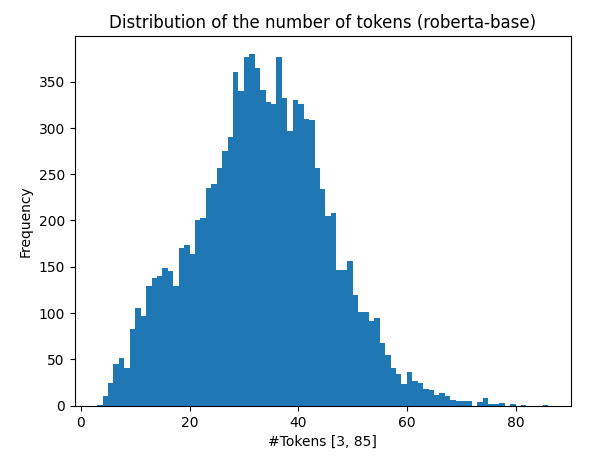

Performance of the NN when reducing the token length and thus truncating some of the tokenized tweets

| Max #Tokens | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Epochtime | training it/s | Full Prediction Time  | prediction it/s | f1-Score on Test Data |
|-------------|------------|----------------|-----------------|---------------------|-----------|---------------|-----------------------|-----------------|-----------------------|
| 85          | 0.354      | 0.862          | 0.402           | 0.833               | 01:10min  | 10.71         | 0:09min               | 41.25           | 0.7619848612279225    |
| 60          | 0.446      | 0.804          | 0.369           | 0.853               | 00:54min  | 14.10         | 0:07min               | 58.25           | 0.7938144329896908    |
| 40          | 0.456      | 0.797          | 0.412           | 0.827               | 00:44min  | 17.05         | 0:05min               | 69.80           | 0.7928186714542191    |

#### Find a faster alternative for RoBERTa

Performance of the three remaining alternatives to RoBERTa

| Base Model              | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Epochtime | training it/s | Full Prediction Time  | prediction it/s | f1-Score on Test Data |
|-------------------------|------------|----------------|-----------------|---------------------|-----------|---------------|-----------------------|-----------------|-----------------------|
| distilroberta-base      | 0.361      | 0.849          | 0.391           | 0.841               | 00:38min  | 19.81         | 00:05min              | 79.88           | 0.8071748878923766    |
| distilbert-base-uncased | 0.445      | 0.808          | 0.381           | 0.842               | 00:35min  | 21.30         | 00:04min              | 81.96           | 0.7764705882352941    |
| prajjwal1/bert-tiny     | 0.372      | 0.843          | 0.410           | 0.826               | 00:05min  | 138.41        | 00:01min              | 317.81          | 0.7636226982337468    |
        

The three histograms of the tested alternatives. One can see that the longest token is 84 respectively 85 and thus the network performance can be compared with the limited number of tokens

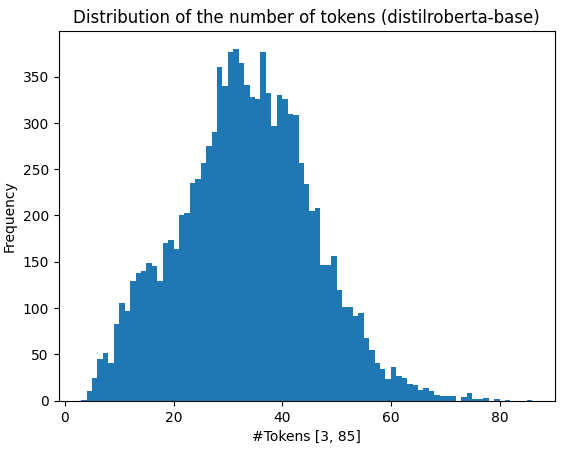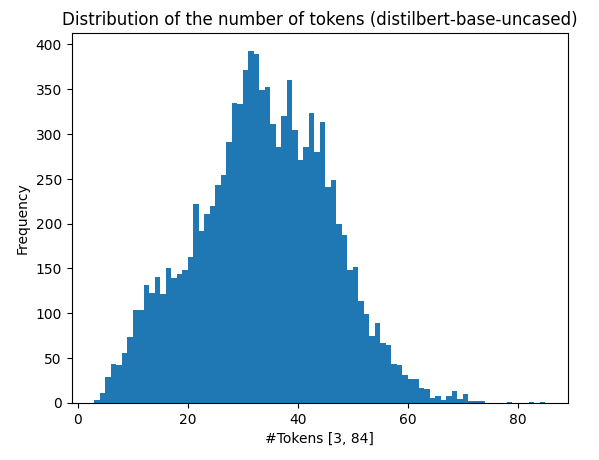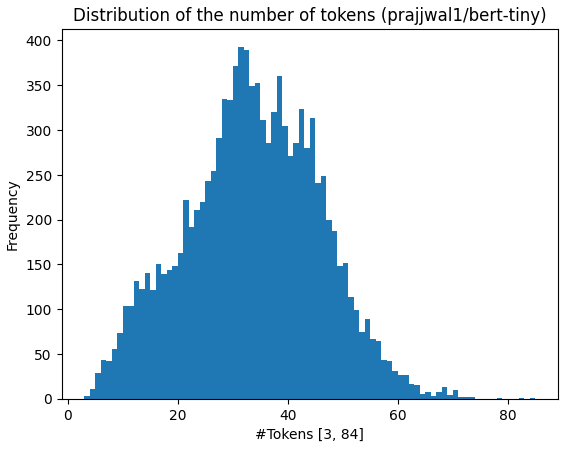


#### Preprocess and optimize textdata
##### Remove links, multiple spaces and transform to lowercase

Tokenized Data after preprocessing the text slightly

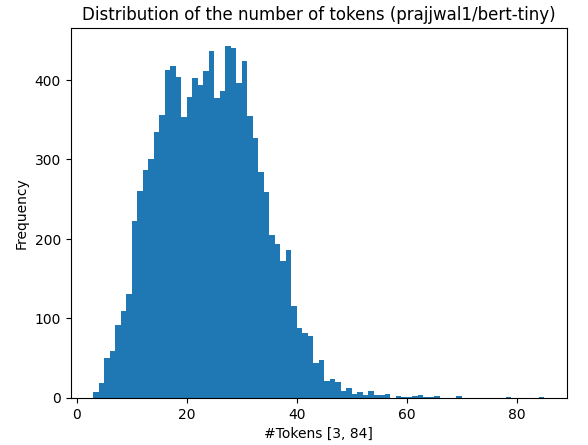

Performance relative to the truncation level

| Max #Tokens | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Epochtime | training it/s | Full Prediction Time  | prediction it/s | f1-Score on Test Data |
|-------------|------------|----------------|-----------------|---------------------|-----------|---------------|-----------------------|-----------------|-----------------------|
| 84          | 0.366      | 0.850          | 0.414           | 0.831               | 00:05min  | 137.31        | 00:01min              | 376.73          | 0.7630675314765356    |
| 60          | 0.375      | 0.841          | 0.407           | 0.822               | 00:05min  | 138.27        | 00:01min              | 385.77          | 0.7579519006982156    |
| 40          | 0.362      | 0.848          | 0.411           | 0.831               | 00:05min  | 137.94        | 00:01min              | 384.17          | 0.7587803936703975    |
| 30          | 0.411      | 0.817          | 0.419           | 0.822               | 00:05min  | 138.14        | 00:01min              | 385.47          | 0.7468305800998848    |
| 20          | 0.417      | 0.821          | 0.435           | 0.816               | 00:05min  | 140.83        | 00:01min              | 385.63          | 0.7363952142030104    |
| 10          | 0.461      | 0.796          | 0.523           | 0.758               | 00:05min  | 132.96        | 00:01min              | 391.42          | 0.6677618069815195    |


##### All the points from above as well as removing mentions, retweets, all special characters and stopwords

Tokenized Data after preprocessing the text even more

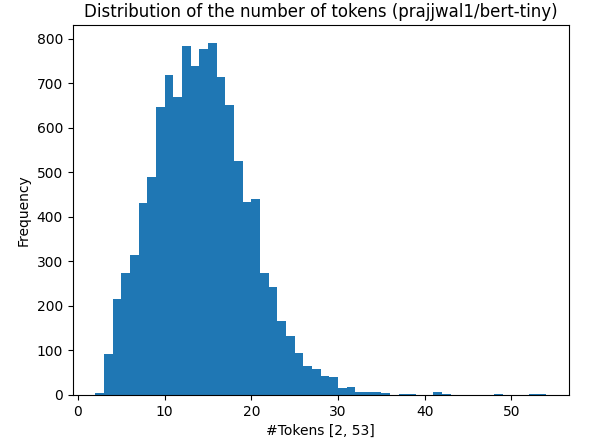

Performance relative to the truncation level


| Max #Tokens | Train Loss | Train Accuracy | Validation Loss | Validation Accuracy | Epochtime | training it/s | Full Prediction Time  | prediction it/s | f1-Score on Test Data |
|-------------|------------|----------------|-----------------|---------------------|-----------|---------------|-----------------------|-----------------|-----------------------|
| 53          | 0.381      | 0.839          | 0.424           | 0.820               | 00:05min  | 137.86        | 00:01min              | 384.77          | 0.7583787996882307    |
| 30          | 0.401      | 0.825          | 0.427           | 0.814               | 00:05min  | 138.48        | 00:01min              | 390.04          | 0.7549167927382754    |
| 20          | 0.364      | 0.846          | 0.425           | 0.821               | 00:05min  | 136.24        | 00:01min              | 385.79          | 0.761350407450524     |


### Step 3 - Consider the features keyword and location

Information contained in keyword only - Different Classifiers run on One Hot Encoded Data

| Model                  | Accuracy | Precision | Recall  | F1-Score |
|------------------------|----------|-----------|---------|----------|
| Logistic Regression    | 0.72142  | 0.69673   | 0.62268 | 0.65763  |
| SVC                    | 0.72142  | 0.69673   | 0.62268 | 0.65763  |
| GaussianNB             | 0.72326  | 0.67484   | 0.68688 | 0.68081  |
| KNeighborsClassifier   | 0.70947  | 0.66840   | 0.64265 | 0.65527  |
| DecisionTreeClassifier | 0.72142  | 0.69673   | 0.62268 | 0.65763  |

Information contained in keyword only - Different Classifiers run on One Hot Encoded Data

| Model                  | Accuracy | Precision | Recall  | F1-Score |
|------------------------|----------|-----------|---------|----------|
| Logistic Regression    | 0.60006  | 0.61687   | 0.18260 | 0.28178  |
| SVC                    | 0.60006  | 0.61687   | 0.18260 | 0.28178  |
| GaussianNB             | 0.44499  | 0.43393   | 0.95792 | 0.59729  |
| KNeighborsClassifier   | 0.44560  | 0.43104   | 0.90728 | 0.58442  |
| DecisionTreeClassifier | 0.60006  | 0.61687   | 0.18260 | 0.28178  |

Result of the classifier with combined data

| Model                  | Accuracy | Precision | Recall  | F1-Score |
|------------------------|----------|-----------|---------|----------|
| Logistic Regression    | 0.72081  | 0.69751   | 0.61840 | 0.65558  |
| SVC                    | 0.71621  | 0.68711   | 0.62340 | 0.65370  |
| GaussianNB             | 0.44713  | 0.43482   | 0.95649 | 0.59786  |
| KNeighborsClassifier   | 0.69415  | 0.65708   | 0.60271 | 0.62872  |
| DecisionTreeClassifier | 0.71253  | 0.68384   | 0.61555 | 0.64790  |


## Inspiration & Other Solutions

- https://www.auroria.io/nlp-disaster-tweet-text-classification-roberta-pytorch/
- https://github.com/nikjohn7/Disaster-Tweets-Kaggle
- https://ai.plainenglish.io/nlp-my-solution-to-kaggles-disaster-tweet-competition-9973ddf48235
- https://www.kaggle.com/code/alsayedhamdy/disaster-tweets-analysis-and-solution
- https://github.com/levist7/NLP_Disaster_Tweet_Analysis
- https://towardsdatascience.com/detecting-disaster-from-tweets-classical-ml-and-lstm-approach-4566871af5f7
